# 降雨量年分布分析

实验目的：统计某处的平均降雨量年分布

目的地：美国中部一处大约200km*200km的地点（理由：数据量足够）

In [1]:
#数据来源于NOAA，使用python的netCDF4和xarray工具包获取
!pip install netCDF4
import xarray as xr

url_us_precipitation = 'http://psl.noaa.gov/thredds/dodsC/Aggregations/CPC_US_precip/precip.V1.0.nc'
us_precipitation = xr.open_dataarray(url_us_precipitation)

     |████████████████████████████████| 4.3MB 7.4MB/s 
     |████████████████████████████████| 296kB 47.5MB/s 


In [2]:
#可查看数据的结构
us_precipitation

<xarray.DataArray 'precip' (time: 25933, lat: 120, lon: 300)>
[933588000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 49.375 49.625 49.875
  * lon      (lon) float32 230.125 230.375 230.625 ... 304.375 304.625 304.875
  * time     (time) datetime64[ns] 1948-01-01 1948-01-02 ... 2018-12-31
Attributes:
    long_name:     Daily Accumulated Precipitation
    valid_range:   [  0. 400.]
    units:         mm
    precision:     2
    var_desc:      Precipitation
    dataset:       CPC Unified Gauge-Based Analysis of Daily Precipitation ov...
    level_desc:    Surface
    statistic:     Daily Accumulation
    parent_stat:   Observation
    actual_range:  [  0.     361.6204]
    _ChunkSizes:   [  1 120 300]

In [3]:
#选取纬度上[76:84]，经度上[146:154]的平面为目的地，即空间为2纬度*2经度
#如下构建目的地的数据集：
target_precipitation = us_precipitation[:, 76:84, 146:154].sum(axis=(1, 2))/64
print(target_precipitation)

<xarray.DataArray 'precip' (time: 25933)>
array([2.7157814e+01, 9.2241306e+00, 8.9973249e-02, ..., 5.3032683e-03,
       0.0000000e+00, 7.5664215e+00], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-01-02 ... 2018-12-31


In [4]:
#将数据集转为numpy形式
import numpy as np
target_precipitation_np = np.array(target_precipitation, dtype='float32')
print(target_precipitation_np.shape)

(25933,)


In [5]:
#由上可知数据时间长度为25933，为1948—2018年数据
#将其按年份划分，首先构建一个区分是否闰年的函数：
def isYear(year):
	if (year%4 == 0) & (year%100 != 0):
		return 366
	elif year%400 == 0:
		return 366
	else:
		return 365

In [6]:
#precip_yearly是将target_precipitation_np按年划分的数据集
#precip_yearly形状为(71, 365), 表示71年，每年365天；若存在闰年，则2月29日的数据平分给前后各一天
precip_yearly = np.zeros((71, 365), dtype='float32')
nun = 0
j = 0

for i in range(1948, 2019):
  num = isYear(i)
  period = target_precipitation_np[nun:nun+num]

  if num == 366:
    period[58] = period[58] + period[59]/2
    period[60] = period[60] + period[59]/2
    period_1 = np.concatenate((period[:59], period[60:]))
  else:
    period_1 = period

  precip_yearly[j] = period_1
  nun = nun+num
  j += 1

In [7]:
#precip_mean_1d为单日年际降水量平均值，长度为365
precip_mean_1d = precip_yearly.mean(axis=0)
print(precip_mean_1d.shape)

(365,)


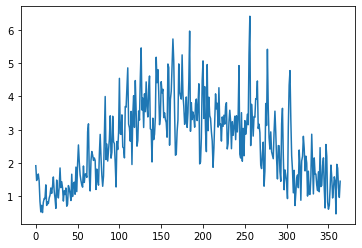

In [8]:
#展示单日年际降水量平均值
import matplotlib.pyplot as plt
plt.plot(precip_mean_1d)

In [13]:
'''
可见图形需要平滑
设Ym为precip_mean_1d的平滑值
'''
Ym = np.zeros((365), dtype='float32')
Ym.shape

(365,)

In [14]:
#构建平滑函数，z代表z日平滑：
def sum_z_days(z, h, k):
  d = z//2
  for i in range(d, 365-d):
    k[i] = h[i-d:i+d+1].sum()/z

  for i in range(d):
    k[i] = h[:i+d+1].sum()/z + h[365+i-d:].sum()/z

  for i in range(365-d, 365):
    k[i] = h[i-d:].sum()/z + h[:i-364+d].sum()/z

  return k

In [15]:
Ym = sum_z_days(11, precip_mean_1d, Ym)

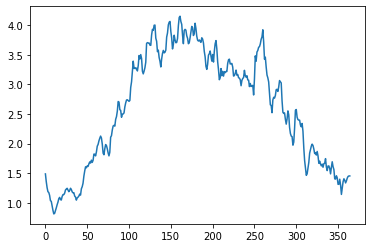

In [16]:
#展示取11日平滑后的效果
plt.plot(Ym)

可见，该地年降雨值的分布具有夏秋多，冬春少的特点